[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tanikina/mi-tutorials/blob/main/notebooks/LLM_Attribution_with_Llama.ipynb)

### Interpreting LLMs for Text Generation

This is based on the official Captum tutorial from [here](https://captum.ai/tutorials/Llama2_LLM_Attribution). Note that the authors also wrote a paper introducing how Captum can help with explaining generaive LLMs [https://arxiv.org/abs/2312.05491](https://arxiv.org/abs/2312.05491)

The official tutorial uses _Llama2 (7b-chat)_ as an example and here we will experiment with the quantized version of _TinyLlama-1.1B-Chat_. We will apply both **perturbation-based** and **gradient-based** algorithms to see how the input prompts lead to the generated content.


In [1]:
!pip install captum
!pip install torch==2.6
!pip install transformers==4.48.0

In [2]:
import torch
import warnings

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import logging

from captum.attr import (
    FeatureAblation, 
    ShapleyValues,
    LayerIntegratedGradients, 
    LLMAttribution, 
    LLMGradientAttribution, 
    TextTokenInput, 
    TextTemplateInput,
    ProductBaselines,
)

# Ignore warnings due to transformers library
logging.set_verbosity_error()

def load_model(model_name):
    n_gpus = torch.cuda.device_count()
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",  # dispatch efficiently the model on the available ressources
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=True)
    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer


model_name = "TheBloke/TinyLlama-1.1B-Chat-v1.0-GPTQ"
# Other options to try out:
# "TechxGenus/Meta-Llama-3-8B-Instruct-GPTQ"
# "TheBloke/deepseek-llm-7B-chat-GPTQ"
model, tokenizer = load_model(model_name)

# Let's generate prediction for the given prompt
eval_prompt = "Arne lives in Berlin, Germany and is a programmer. His interests include"
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
model.eval()
with torch.no_grad():
    output_ids = model.generate(model_input["input_ids"], max_new_tokens=15)[0]
    response = tokenizer.decode(output_ids, skip_special_tokens=True)
    print(response)

2025-02-17 11:37:26.860360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739792246.883301    6358 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739792246.890272    6358 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/root/miniconda3/envs/nlp-env/lib/python3.11/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:410: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/root/miniconda3/envs/nlp-env/lib/python3.11/site-packages/auto_gptq/nn_modules/triton_utils/kernels.py:418: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated.

Arne lives in Berlin, Germany and is a programmer. His interests include programming languages, web development, and open source software. He is a member


#### Perturbation-based Attribution

We can start with the simplest `FeatureAblation` method, which ablates each of the features of the input string to see how it affects the predicted probability of the target string. We pass the model to the `FeatureAblation` constructor and then wrap it with the `LLMAttribution` class to make it work with the text input.

Note that here we need some instance of `InterpretableInput` to handle the conversion between some interpretable input types (e.g. tokens based on the given tokenizer) and a tensor, because Captum perturbs by default **at the tensor level** and we want to make sure that we modify some meanigful inputs like tensors representing the text segments, not a tensor of token indices.

In [3]:
fa = FeatureAblation(model)

llm_attr = LLMAttribution(fa, tokenizer)

skip_tokens = [1]  # skip the special token for the start of the text <s>
inp = TextTokenInput(
    eval_prompt, 
    tokenizer,
    skip_tokens=skip_tokens,
)

In [4]:
# Prepare the targets
gold_target = "programming languages, web development, and open source software"
fake_target = "baking pies and playing chess"

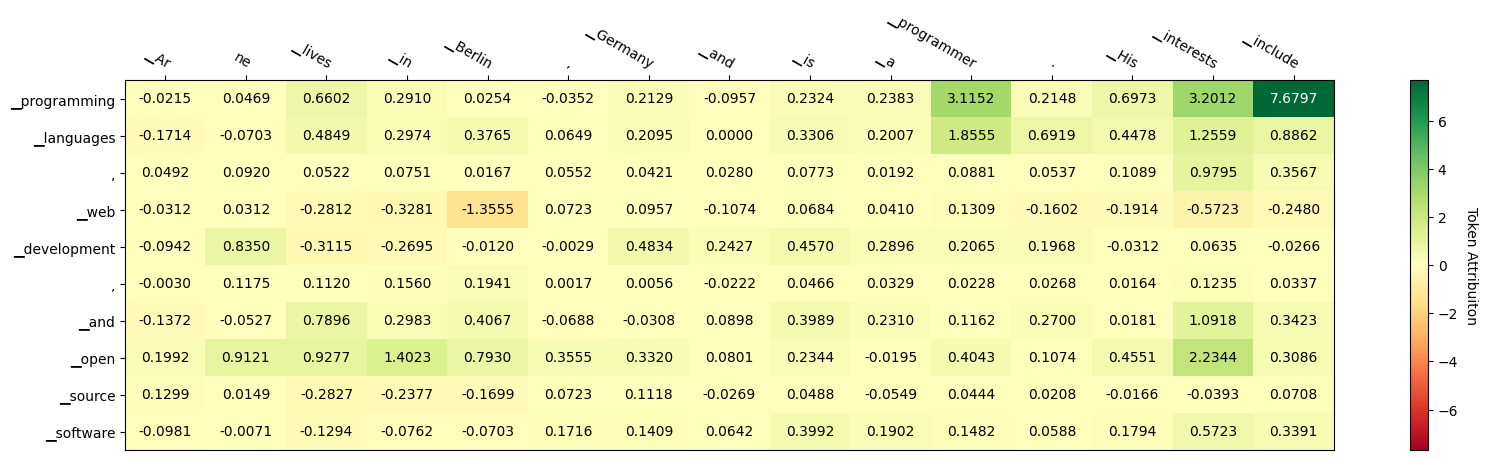

In [5]:
# Calculate attribution scores for the gold target
attr_res = llm_attr.attribute(inp, target=gold_target, skip_tokens=skip_tokens)
attr_res.plot_token_attr(show=True)

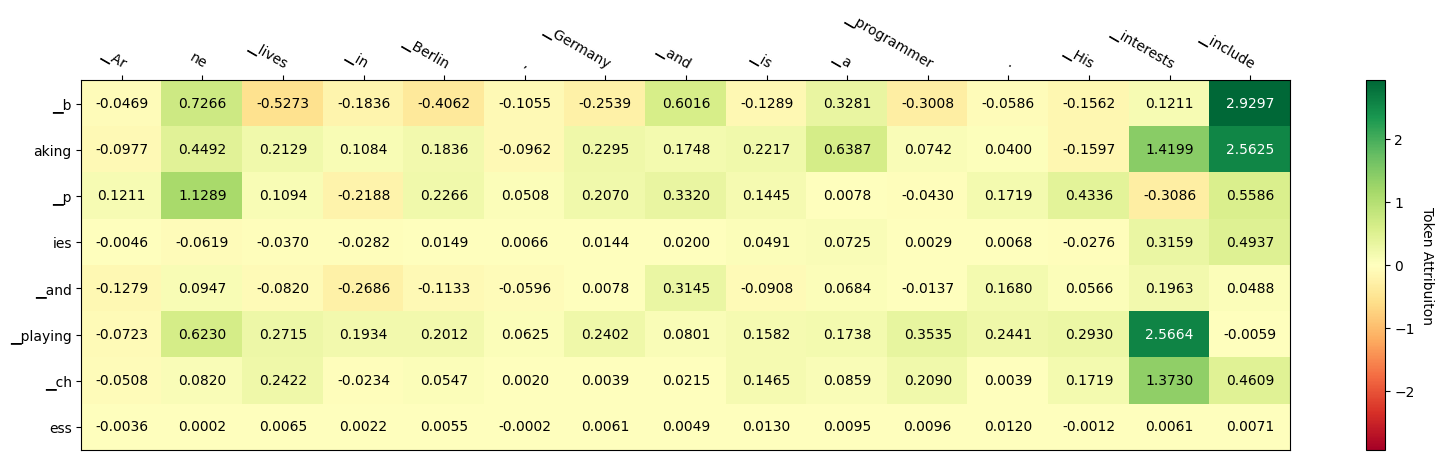

In [6]:
# Calculate attribution scores for the fake target
attr_res = llm_attr.attribute(inp, target=fake_target, skip_tokens=skip_tokens)
attr_res.plot_token_attr(show=True)

It is not always meaningful to use individual tokens as intepretable features because tokenizers often split tokens, e.g. name "Arne" was split into "_Ar" and "ne" which results in two separate attributions for the same word.

To address this, Captum offers another interpretable input class, `TextTemplateInput`, whose interpretable features are certain segments (e.g., words, phrases) of the text defined by the user. For instance, our prompt above contains information about name, city, occupation, and pronoun. Let's define them as the interpretable features to get their attribution.

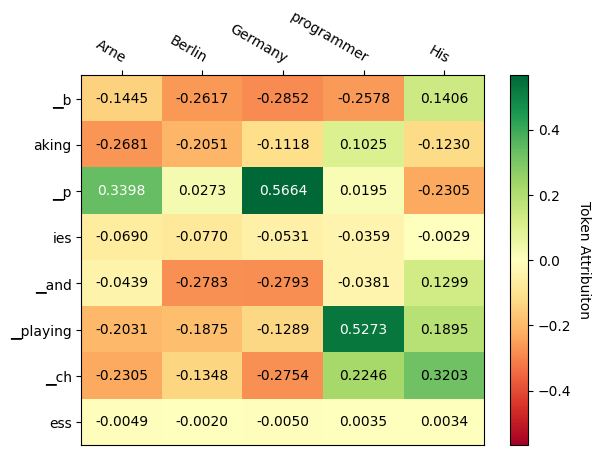

In [7]:
inp = TextTemplateInput(
    template="{} lives in {}, {} and is a {}. {} interests include", 
    values=["Arne", "Berlin", "Germany", "programmer", "His"],
)

attr_res = llm_attr.attribute(inp, target=fake_target, skip_tokens=skip_tokens)

attr_res.plot_token_attr(show=True)

Perturbation-based algrotihms calculate the attribution by switching the features between "presence" and "absence" states. So what should a text feature look like here when it is in "absence" in the above example? Captum allows users to set the **baselines**, i.e., the reference values, to use when a feature is absent. By default, TextTemplateInput uses empty string '' as the baselines for all, which is equivalent to the removal of the segments. This may not be perfect for the same out-of-distribution reason. For example, when the feature "name" is absent, the prompt loses its subject and no longer makes much sense.

To improve it, let's manually set the baselines to something that still fit the context of the original text and keep it within the natural data distribution.

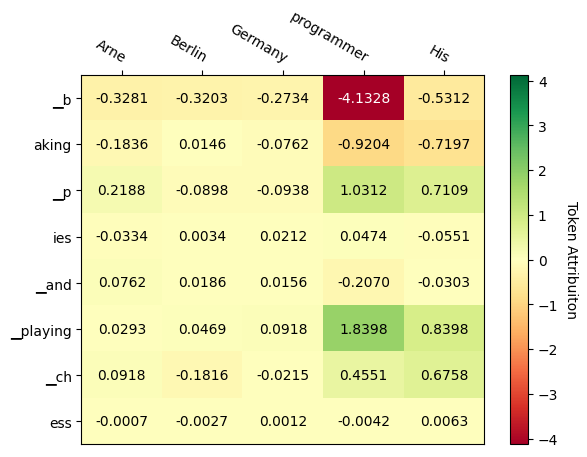

In [8]:
inp = TextTemplateInput(
    template="{} lives in {}, {} and is a {}. {} interests include", 
    values=["Arne", "Berlin", "Germany", "programmer", "His"],
    baselines=["Sarah", "Paris", "France", "baker", "Her"],
)

attr_res = llm_attr.attribute(inp, target=fake_target, skip_tokens=skip_tokens)

attr_res.plot_token_attr(show=True)

Ideally, we would prefer a distribution of baselines so that the attribution method can sample from it. Here, we can leverage the `ProductBaselines` to define a Cartesian product of different baseline values of various features. And we can specify `num_trials` in attribute to average over multiple trials.

Another issue we notice from the above results is that there are correlated aspects of the prompt which should be ablated together to ensure that the input remains in distribution, e.g. Berlin, Germany should be ablated with Paris, France. We can accomplish this using a mask as defined below, which will group (city, country) and (name, pronoun). `TextTemplateFeature` accepts the argument mask allowing us to set the group indices. To make it more explicit, we can also define the template and its values in a dictionary format instead of a list.

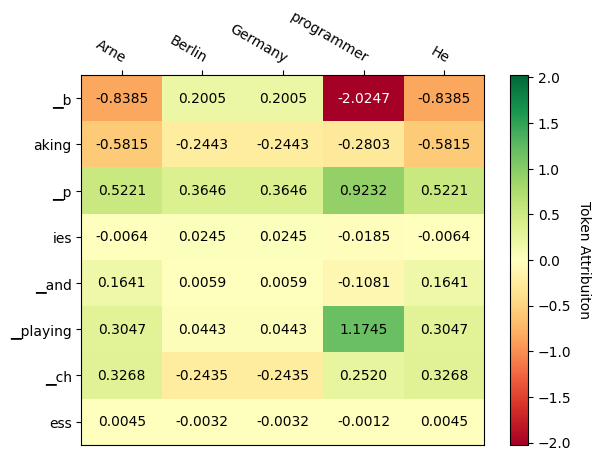

In [9]:
baselines = ProductBaselines(
    {
        ("name", "pronoun"):[("Sarah", "Her"), ("Lukas", "His"), ("Marina", "Her")],
        ("city", "country"): [("Berlin", "Germany"), ("Paris", "France"), ("Cairo", "Egypt")],
        "occupation": ["doctor", "baker", "teacher"], 
    }
)

inp = TextTemplateInput(
    "{name} lives in {city}, {country} and is a {occupation}. {pronoun} interests include", 
    values={"name": "Arne", "city": "Berlin", "country": "Germany", "occupation": "programmer", "pronoun": "He"}, 
    baselines=baselines,
    mask={"name": 0, "city": 1, "country": 1, "occupation": 2, "pronoun": 0},
)

attr_res = llm_attr.attribute(inp, target=fake_target, skip_tokens=skip_tokens, num_trials=3)

attr_res.plot_token_attr(show=True)

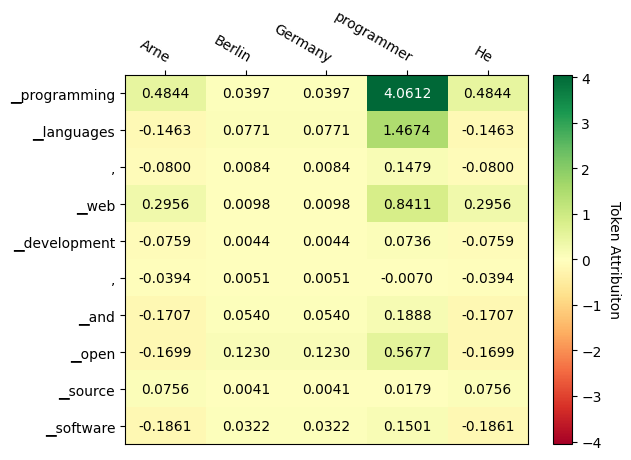

In [10]:
attr_res = llm_attr.attribute(inp, target=gold_target, skip_tokens=skip_tokens, num_trials=3)

attr_res.plot_token_attr(show=True)

One potential issue with the current approach is using **Feature Ablation**. If the model learns complex interations between the prompt features, the true importance may not be reflected in the attribution scores. Consider a case where the model predicts a high probability of playing chess if a person is either a programmer or has a name Arne. By ablating a feature one at a time, the probability may appear to be unchanged when ablating each feature independently, but may drop substantially when perturbing both together.

To address this, we can apply **alternate perturbation-based attribution methods** available in Captum such as `ShapleyValue(Sampling)`, `KernelShap` and `Lime`, which ablate different subgroups of features and may result in more accurate scores.

We will use `ShapleyValue` below because we essentially only have three features now after grouping and the computation is tractable.

What is `ShapleyValue`? It is a perturbation-based approach to compute attribution, based on the concept of Shapley Values from cooperative game theory. This method involves taking a **random permutation of the input features** and adding them **one-by-one to the given baseline**. The output difference after adding each feature corresponds to its attribution, and these difference are averaged when repeating this process n_samples times, each time choosing a new random permutation of the input features.

By default, each scalar value within the input tensors are taken as a feature and added independently. Passing a feature mask, allows **grouping features to be added together**. This can be used in cases such as images, where an entire segment or region can be grouped together, measuring the importance of the segment (feature group). Each input scalar in the group will be given the same attribution value equal to the change in output as a result of adding back the entire feature group.

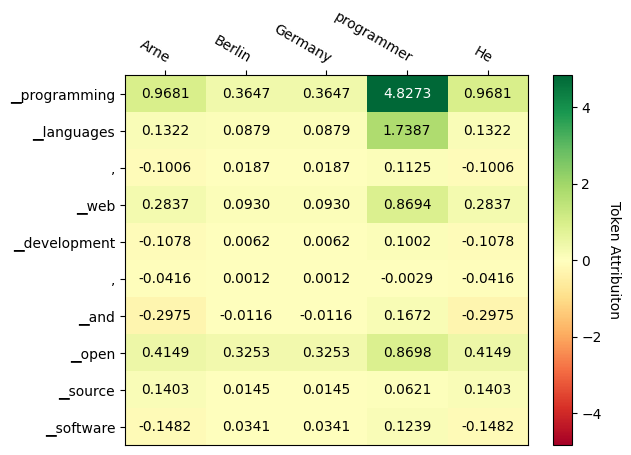

In [11]:
sv = ShapleyValues(model) 

sv_llm_attr = LLMAttribution(sv, tokenizer)

attr_res = sv_llm_attr.attribute(inp, target=gold_target, num_trials=3)

attr_res.plot_token_attr(show=True)

#### Gradient-based Attribution

As an alternative to perturbation-based attribution, we can use **gradient-based methods** to attribute each feature's contribution to a target sequence being generated. For LLMs, the only supported method at present is `LayerIntegratedGradients`. Layer Integrated Gradients is a variant of Integrated Gradients that assigns an **importance score to layer inputs or outputs**.

Integrated Gradients works by assigning an importance score to each input feature by approximating **the integral of gradients of a function's output with respect to the inputs** along the path from given references to inputs. To instantiate, we can simply wrap our gradient-based attribution method with `LLMGradientAttribution`. Here, we measure the importance of each input token to the embedding layer `model.embed_tokens` of the LLM.

<img src="images/integrated_gradients_illustration.png" alt="Integrated Gradients" width="600"/>

[Image source and explanation video](https://www.fiddler.ai/blog/video-ai-explained-what-are-integrated-gradients)

Also here is a very nice explanation and comparison of different feature attribution baselines: [https://distill.pub/2020/attribution-baselines/](https://distill.pub/2020/attribution-baselines/)
<img src="images/integrated_gradients_formula1.png" alt="Integrated Gradients" width="700"/>


In [12]:
lig = LayerIntegratedGradients(model, model.model.embed_tokens)

llm_attr = LLMGradientAttribution(lig, tokenizer)

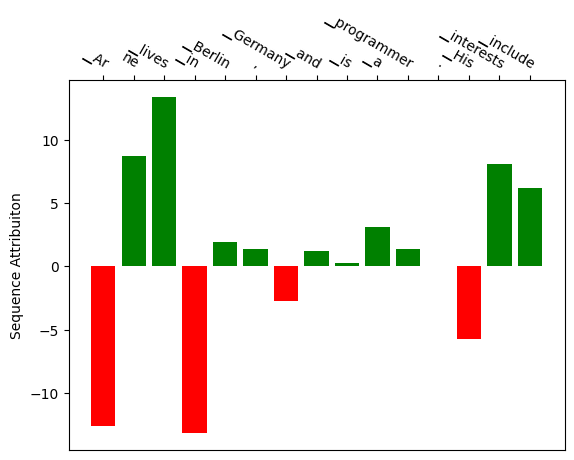

In [13]:
inp = TextTokenInput(
    eval_prompt,
    tokenizer,
    skip_tokens=skip_tokens,
)

attr_res = llm_attr.attribute(inp, target=gold_target) #, skip_tokens=skip_tokens)
attr_res.plot_seq_attr(show=True)

Layer Integrated Gradients estimates that the most important input token in the prediction of the subsequent tokens in the sentence is the word, "lives". We can visualize further token-level attribution at the embedding layer as well.

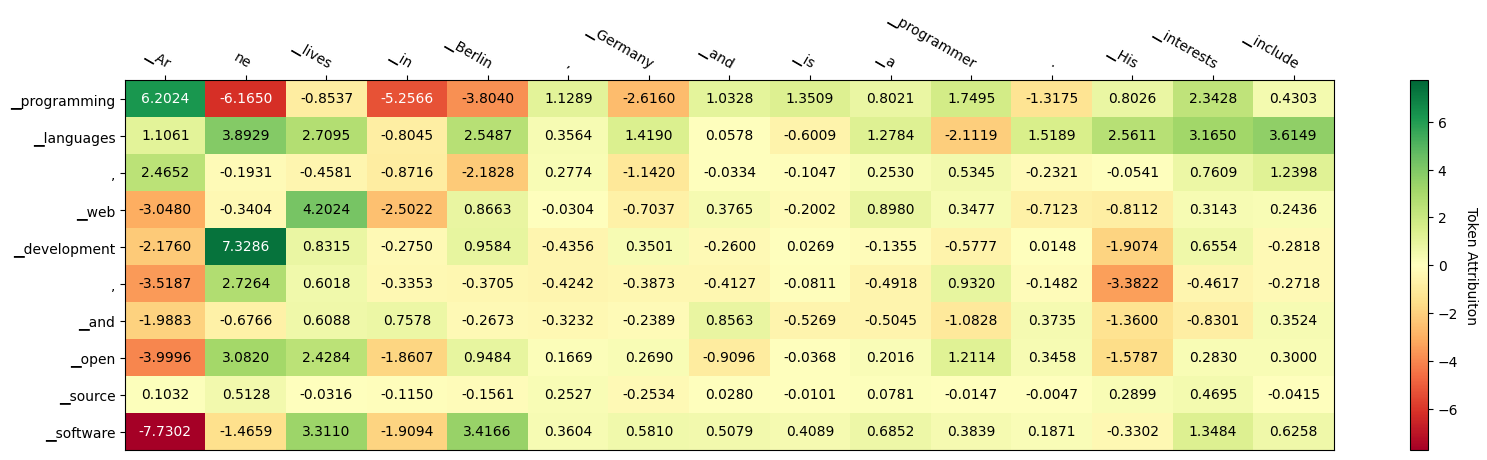

In [14]:
attr_res.plot_token_attr(show=True)

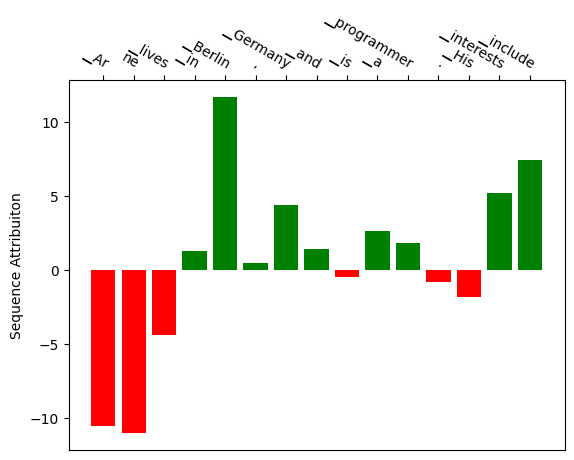

In [15]:
attr_res = llm_attr.attribute(inp, target=fake_target) #, skip_tokens=skip_tokens)
attr_res.plot_seq_attr(show=True)

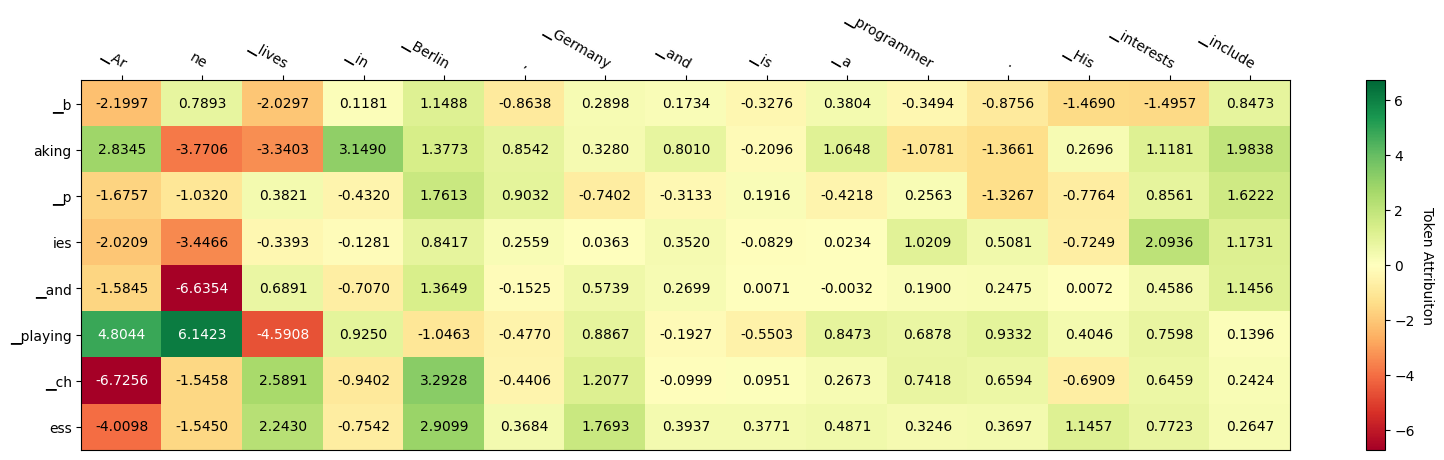

In [16]:
attr_res.plot_token_attr(show=True)

#### Back to Shapley Values

Let's now consider a more complex example, where we use the LLM as a few-shot learner to classify sample movie reviews as positive or negative. We want to measure the relative impact of the few shot examples. Since the prompt changes slightly in the case that no examples are needed, we define a prompt function rather than a format string in this case.

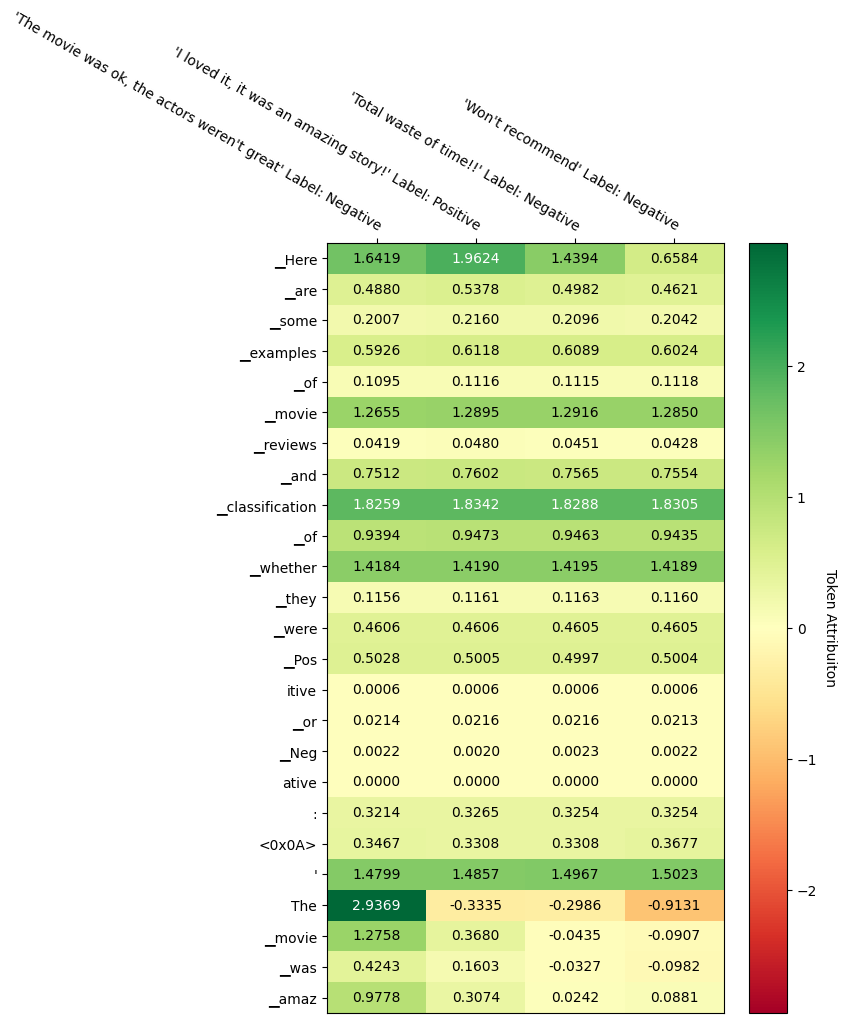

In [17]:
def prompt_fn(*examples):
    main_prompt = "Classify as Positive or Negative the following review. 'I really liked the Avengers, it had a captivating plot!' Label:"
    subset = [elem for elem in examples if elem]
    if not subset:
        prompt = main_prompt
    else:
        prefix = "Here are some examples of movie reviews and classification of whether they were Positive or Negative:\n"
        prompt = prefix + " \n".join(subset) + "\n " + main_prompt
    return "[INST] " + prompt + "[/INST]"

input_examples = [
    "'The movie was ok, the actors weren't great' Label: Negative", 
    "'I loved it, it was an amazing story!' Label: Positive",
    "'Total waste of time!!' Label: Negative", 
    "'Won't recommend' Label: Negative",
]
inp = TextTemplateInput(
    prompt_fn, 
    values=input_examples,
)

attr_res = sv_llm_attr.attribute(inp)

attr_res.plot_token_attr(show=True)

#### ⁉️ Things to Try
To see all the available options, please have a look at the API documentation [here](https://captum.ai/api/).
1. Test a different model and prompt (e.g. have a look at _TheBloke/deepseek-llm-7B-chat-GPTQ_ or _TechxGenus/Meta-Llama-3-8B-Instruct-GPTQ_).
2. Use `KernelShap` or `Lime` instead of `ShapleyValues`.
3. Experiment with different baselines and grouped features. Do you notice any patterns?